# Predicting a transaction as fraud or genuine

---
embed-resources: true
---

## Introduction

Today, I develop a model where it will predict a transaction is fraud or genuine. As soon as a transaction has been made by someone, the model will identify whether the transaction was fraud or genuine based on information of the transactions, such as location, time, amount, etc. In this case, 0 represents a transaction being genuine and 1 being frauds. This model only works on this dataset.

## Methods

In [49]:
# imports
# imports
# basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

# machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# preprocessing imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    fbeta_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.metrics import confusion_matrix
from pprint import pprint

### Data

In [50]:
# load data
fraud_train = pd.read_parquet(
    "https://cs307.org/lab/data/fraud-train.parquet",
)
fraud_test = pd.read_parquet(
    "https://cs307.org/lab/data/fraud-test.parquet",
)
fraud_train

,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,Amount,Fraud
137250,-0.514509,0.899378,1.627215,-0.142250,0.005250,-0.235422,0.482540,0.247403,-0.562327,-0.166813,...,-0.143290,-0.390205,0.030719,0.184779,-0.348711,0.073253,0.273217,0.107938,3.59,0
132979,-0.813568,-0.373893,1.152977,-0.449774,-3.868866,2.780636,3.654192,-0.672442,0.753230,-0.662803,...,-0.376783,-0.004239,0.074801,0.124238,-0.448493,0.861423,-0.093639,-0.711632,798.01,0
78191,-2.443142,3.258831,-0.791511,0.223548,0.007932,-1.263044,1.220214,-0.418068,1.860453,4.184883,...,-0.348587,0.531679,0.058990,0.371638,-0.207398,-0.505837,0.524542,-0.343895,1.79,0
113508,-0.397300,0.922104,1.224699,-0.334974,0.322603,-0.117372,0.534683,0.175550,-0.486404,-0.120147,...,-0.239303,-0.695001,-0.128231,-0.536463,-0.138971,0.107526,0.255644,0.100814,2.69,0
199222,1.994046,-0.367813,-0.462867,0.338661,-0.485326,-0.241576,-0.590987,0.089319,1.413224,-0.149292,...,-0.196388,-0.484457,0.421867,0.601393,-0.448014,-0.646256,0.027632,-0.027244,4.49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76424,-0.033583,-0.487672,1.435406,-2.759369,-1.785638,0.402364,-2.306038,-2.287179,0.129717,-1.036412,...,-1.286823,0.824100,0.018890,0.000018,0.301618,0.081215,0.163422,0.252456,10.00,0
264579,-0.731245,1.151677,0.912393,-0.653540,0.700577,-0.461372,1.093273,-0.126254,-0.339171,-0.467356,...,-0.368185,-0.991854,-0.376461,-0.661608,0.554237,0.450650,0.076395,0.096252,6.99,0
204332,2.135923,-0.714182,-1.842502,-0.587267,0.090754,-0.465733,-0.024834,-0.328747,-0.659832,0.853241,...,-0.537267,-1.081138,0.196589,0.087797,-0.111583,0.479888,-0.082523,-0.053305,64.90,0
167301,-0.335632,0.939736,-2.961515,-1.224739,4.446891,2.352092,0.789725,0.609460,-0.746845,-1.580751,...,-0.002116,0.009686,-0.428325,0.536043,0.278736,0.680976,-0.069295,0.051891,0.76,0


From the train data above, each row represents a transaction and shows its information and whether or not it was fraud or genuine. 
The variables in the dataset are:
### Response 

**`Fraud`**

- [int64] status of the transaction. 1 indicates a fraudulent transaction and 0 indicates not fraud, a genuine transaction.


### Features

**`Amount`**

- [float64] amount (in dollars) of the transaction.

**`PC-01 - PC28`**

- [float64] the 28 principal components that encode information such as location and type of purchase while preserving customer privacy.


In [51]:
# summary statistics
gen = fraud_train[fraud_train['Fraud'] == 0]
gen.shape

(53961, 30)

In [52]:
fraud = fraud_train[fraud_train['Fraud'] == 1]
fraud.shape

(315, 30)

In [53]:
total = 54276
gen_porp = 53961 / total
fraud_porp = 315 / total
print(f'Genuine proportion is: {gen_porp}')
print(f'Fraud proportion is: {fraud_porp}')

Genuine proportion is: 0.9941963298695556
Fraud proportion is: 0.005803670130444395


In [54]:
none_amount = fraud_train['Amount'].describe()
gen_amount = gen['Amount'].describe()
fraud_amount = fraud['Amount'].describe()
print(none_amount)
print('')
print(gen_amount)
print('')
print(fraud_amount)

count    54276.000000
mean        88.197903
std        241.535617
min          0.000000
25%          5.490000
50%         21.690000
75%         76.000000
max      10199.440000
Name: Amount, dtype: float64

count    53961.000000
mean        88.065104
std        241.451144
min          0.000000
25%          5.500000
50%         21.800000
75%         75.970000
max      10199.440000
Name: Amount, dtype: float64

count     315.000000
mean      110.947016
std       254.978960
min         0.000000
25%         1.000000
50%         6.990000
75%        99.990000
max      2125.870000
Name: Amount, dtype: float64


From the summary statistics above, we are able to see how many transactions were genuine and fraud and we can see descriptive statistics of them such as the mean amount of each category. We also notice that there are far more genuine transactions than frauds. 

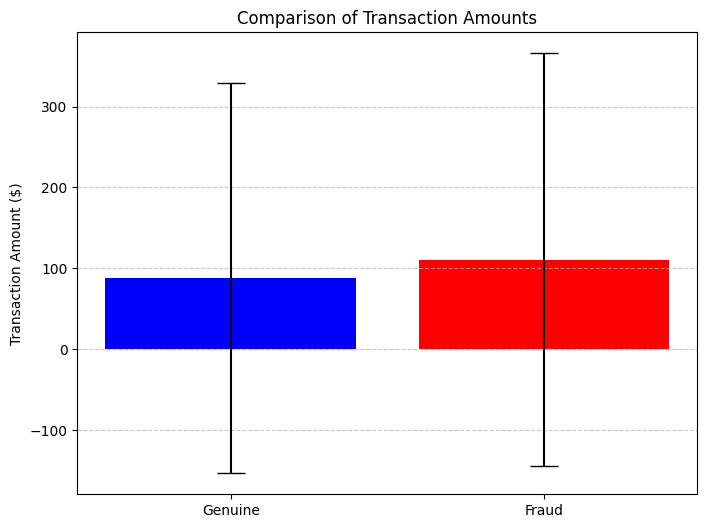

In [55]:
# exploratory visualization
categories = ['Genuine', 'Fraud']
means = [none_amount['mean'], fraud_amount['mean']]
stds = [none_amount['std'], fraud_amount['std']]

plt.figure(figsize=(8, 6))
plt.bar(categories, means, yerr=stds, capsize=10, color=['blue', 'red'])
plt.ylabel('Transaction Amount ($)')
plt.title('Comparison of Transaction Amounts')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

The bar plot above lets us see the range of transaction costs of genuine transactions and frauds. We see that fraud transactions have higher costs than of genuine which makes sense since scammers are trying to get the most money they can. 

### Models

In [56]:
# process data for ML
X_train = fraud_train.drop("Fraud", axis=1)
y_train = fraud_train["Fraud"]

# create X and y for test
X_test = fraud_test.drop("Fraud", axis=1)
y_test = fraud_test["Fraud"]


In [57]:
# train models
rf = RandomForestClassifier(random_state=10)

weights_list = [
    {0: 1, 1: 3},
    "balanced",
]

scoring = {
    "recall": make_scorer(recall_score),
    "precision": make_scorer(precision_score, zero_division=0),
    "f1": make_scorer(fbeta_score, beta=1),
}

rf_param_grid = {
    "n_estimators": [200],
    "max_depth": [10],
    "class_weight": weights_list,
}

rf_grid = GridSearchCV(
    rf,
    rf_param_grid,
    cv=5,
    scoring=scoring,
    refit="f1",
)

_ = rf_grid.fit(X_train, y_train)

After fitting the model with the train data, we will use this for our test data.

## Results

In [58]:
# report model metrics
y_pred = rf_grid.predict(X_test)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
print("")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")



Test Precision: 0.9846153846153847
Test Recall: 0.810126582278481


When using the final model on our test data, we are able to achieve a test precision score of 0.98 and a test recall score of 0.81

In [59]:
# serialize model
dump(rf_grid, 'fraud.joblib')

['fraud.joblib']

## Discussion

Our final model achieves a precision score of 0.98% and a recall score of 0.81 which accomplishes our goal of making a model that outperforms a precision score of 0.90 and a recall score of 0.80. This means that when our model predicts a transaction is fraud or not, it is correct 98% of the time. With a recall value of 0.81, this means that our model correctly identifies 81% of all actual fraud transactions.

Even though our model out preforms these measurements, we should not use this model. Our precision score is very high which is very good but our recall value is not. When having a recall value of 0.81, this also means that the model misses 19% of all actual fraud cases which can lead to very serious consequences for the customer. 

Yes, it is nice that our model achieves a very high precision score, as a bank, our priority is the recall value. We do not want our model to predict a transaction as genuine when it is actually a fraud or a type 1 error. And considering that our recall value is only 0.81, we should not use this model. Many of our customers will get scammed which will cause many people to stop choosing our bank.

To improve the recall value, we can trade-off with precision where this will increase our recall value but at the same time decrease the precision. We can  try using different models such as K_Nearest_Neighbors and see how that model preforms. If Random Forrest is the best model, then we can increase the penalty for misclassifying fraud transactions by adjusting the class weights in the model.

The confusions matrix below shows how well our model classified each transaction and shows which type of transactions it was able to correctly and incorrectly label. We see that the model did a very good job of correctly predicting a transaction when the transaction was actually genuine. On the other hand, we see the model struggles to identify frauds. Out of all 79 fraud transactions, our model was only able to label 64 of them correctly and 15 of them incorrectly. This does not seem much but this is crucial in our case since we do not want a single customer's transactions predicted to be genuine when it is actually a fraud because the customer can lose a significant amount of money. This not only hurts the customer but it will also hurt sales and profits for the bank as well which will be costly in the long run.

Overall, we should not use this model because the recall value is too low and the model's percentage of type 1 errors are too high.

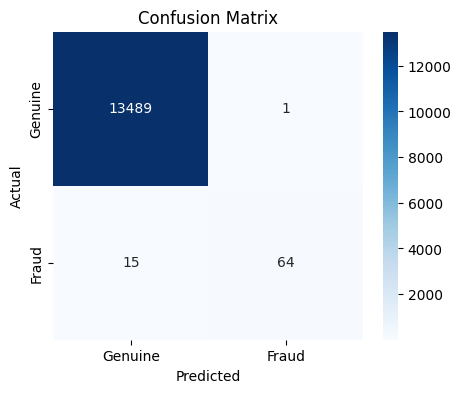

In [60]:
# summary figure
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Genuine", "Fraud"], yticklabels=["Genuine", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()